# Data modelling

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
import shap

from scipy import stats

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, roc_auc_score, confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from tensorflow.keras import layers, models, regularizers

import lightgbm as lgb

## Load preprocessed dataset as agreed by group

In [2]:
# Load preprocessed data set from /data folder
current_dir = os.getcwd()
base_dir = os.path.abspath(os.path.join(current_dir, "..", "data"))
file_path = os.path.join(base_dir, "preprocessed_treated_outliers.csv")
    
preprocessed_df = pd.read_csv(file_path)

print(preprocessed_df.head())

                  Time Origin Dest                 Carrier  Cancelled  \
0  2021-01-01 09:00:00    LAX  JFK  American Airlines Inc.      False   
1  2021-01-02 09:00:00    LAX  JFK  American Airlines Inc.      False   
2  2021-01-03 09:00:00    LAX  JFK  American Airlines Inc.      False   
3  2021-01-03 09:00:00    LAX  JFK  American Airlines Inc.      False   
4  2021-01-04 09:00:00    LAX  JFK  American Airlines Inc.      False   

  CancellationReason  Delayed  DepDelayMinutes  CarrierDelay  \
0      Not Cancelled    False              0.0           0.0   
1      Not Cancelled     True              2.0           0.0   
2      Not Cancelled     True             25.0          28.0   
3      Not Cancelled     True             25.0          28.0   
4      Not Cancelled    False              0.0           0.0   

   Weather_Delay_Length  ...  Temperature  Feels_Like_Temperature  \
0                   0.0  ...         56.0                    55.9   
1                   0.0  ...         5

In [3]:
# Check the datatype of the 'Time' column
print(f"Data type of 'Time': {preprocessed_df['Time'].dtype}")

# If not datetime, convert it to datetime
if not pd.api.types.is_datetime64_any_dtype(preprocessed_df['Time']):
    preprocessed_df['Time'] = pd.to_datetime(preprocessed_df['Time'])
    print(f"After conversion, Data type of 'Time': {preprocessed_df['Time'].dtype}")

Data type of 'Time': object
After conversion, Data type of 'Time': datetime64[ns]


In [4]:
# Extract hour, day of the week, and month from the Time column
preprocessed_df['Hour'] = preprocessed_df['Time'].dt.hour
preprocessed_df['Day_Of_Week'] = preprocessed_df['Time'].dt.dayofweek
preprocessed_df['Month'] = preprocessed_df['Time'].dt.month

## Train and Test split

In [5]:
preprocessed_df.columns

Index(['Time', 'Origin', 'Dest', 'Carrier', 'Cancelled', 'CancellationReason',
       'Delayed', 'DepDelayMinutes', 'CarrierDelay', 'Weather_Delay_Length',
       'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Temperature',
       'Feels_Like_Temperature', 'Altimeter_Pressure', 'Sea_Level_Pressure',
       'Visibility', 'Wind_Speed', 'Wind_Gust', 'Precipitation',
       'Ice_Accretion_3hr', 'Weather_Delayed', 'Hour', 'Day_Of_Week', 'Month'],
      dtype='object')

In [6]:
# Define X and y_pred. Drop all delay columns from X (as per group decision) and 'Delayed' is the new y_pred.
X = preprocessed_df.drop(columns=[
    'Time', 'Cancelled', 'CancellationReason', 'Delayed', 
    'DepDelayMinutes', 'CarrierDelay', 'Weather_Delay_Length', 
    'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
    'Weather_Delayed'
    ])
y = preprocessed_df['Delayed']

In [7]:
# Checking columns of X
X.columns

Index(['Origin', 'Dest', 'Carrier', 'Temperature', 'Feels_Like_Temperature',
       'Altimeter_Pressure', 'Sea_Level_Pressure', 'Visibility', 'Wind_Speed',
       'Wind_Gust', 'Precipitation', 'Ice_Accretion_3hr', 'Hour',
       'Day_Of_Week', 'Month'],
      dtype='object')

In [8]:
# Train/test split of preprocessed_df while keeping ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, # 80% train, 20% test
    random_state=42, # Reproducibility
    stratify=y # # Maintain the class distribution
)

In [9]:
# Sample only 10% of the data for quick testing
X_sample, _, y_sample, _ = train_test_split(
    X, y, 
    test_size=0.9,  # Keep only 10% for the sample
    random_state=42, # Reproducibility
    stratify=y  # Maintain the class distribution
)

In [10]:
# Split the sampled data into train and test sets
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_sample, y_sample, 
    test_size=0.2,  # 80% train, 20% test
    random_state=42, # Reproducibility
    stratify=y_sample  # Maintain the class distribution in the split
)

In [11]:
X_train_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1211560 entries, 11549781 to 1256723
Data columns (total 15 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Origin                  1211560 non-null  object 
 1   Dest                    1211560 non-null  object 
 2   Carrier                 1211560 non-null  object 
 3   Temperature             1211560 non-null  float64
 4   Feels_Like_Temperature  1211560 non-null  float64
 5   Altimeter_Pressure      1211560 non-null  float64
 6   Sea_Level_Pressure      1211560 non-null  float64
 7   Visibility              1211560 non-null  float64
 8   Wind_Speed              1211560 non-null  float64
 9   Wind_Gust               1211560 non-null  float64
 10  Precipitation           1211560 non-null  float64
 11  Ice_Accretion_3hr       1211560 non-null  float64
 12  Hour                    1211560 non-null  int32  
 13  Day_Of_Week             1211560 non-null  int32  
 14  

In [12]:
# Identify categorical, binary, and numeric features
categorical_features = ['Origin', 'Dest', 'Carrier']
numeric_features = ['Temperature', 'Feels_Like_Temperature', 'Altimeter_Pressure', 
                    'Sea_Level_Pressure', 'Visibility', 'Wind_Speed',
                    'Wind_Gust', 'Precipitation', 'Ice_Accretion_3hr', 
                    'Hour', 'Day_Of_Week', 'Month']

# One-hot encode categorical features
encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train_sample[categorical_features])
X_test_encoded = encoder.transform(X_test_sample[categorical_features])

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sample[numeric_features])
X_test_scaled = scaler.transform(X_test_sample[numeric_features])

#Concatenate arrays to form one array
X_train_preprocessed = np.hstack([X_train_encoded.toarray(), X_train_scaled])
X_test_preprocessed = np.hstack([X_test_encoded.toarray(), X_test_scaled])

In [13]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_preprocessed, y_train_sample)

## FCNN

In [14]:
# Build the FNN model
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(X_train_balanced.shape[1],), 
                       kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu',
                       kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))  # Single output for binanry classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_balanced, y_train_balanced, epochs=20, batch_size=64, validation_split=0.1, callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])


/Users/markmans/.pyenv/versions/3.10.6/envs/lateguru/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
20811/20811 ━━━━━━━━━━━━━━━━━━━━ 21s 965us/step - accuracy: 0.6303 - loss: 0.6704 - val_accuracy: 0.5155 - val_loss: 0.7134
Epoch 2/20
20811/20811 ━━━━━━━━━━━━━━━━━━━━ 20s 938us/step - accuracy: 0.6351 - loss: 0.6531 - val_accuracy: 0.4855 - val_loss: 0.7424
Epoch 3/20
20811/20811 ━━━━━━━━━━━━━━━━━━━━ 21s 991us/step - accuracy: 0.6356 - loss: 0.6526 - val_accuracy: 0.4890 - val_loss: 0.7391
Epoch 4/20
20811/20811 ━━━━━━━━━━━━━━━━━━━━ 21s 986us/step - accuracy: 0.6358 - loss: 0.6521 - val_accuracy: 0.4251 - val_loss: 0.7750


In [15]:
# Use model.predict to get y_pred values for evaluation
y_pred = (model.predict(X_test_preprocessed) > 0.5).astype(int)

9466/9466 ━━━━━━━━━━━━━━━━━━━━ 3s 274us/step


In [16]:
y_pred

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [17]:
# Calculate F1 score
f1 = f1_score(y_test_sample, y_pred)
print(f"F1 Score on the test set: {f1}")

F1 Score on the test set: 0.48965189319052027


In [18]:
# Calculate Recall
recall = recall_score(y_test_sample, y_pred)
print(f"Recall: {recall}")

Recall: 0.4148538279520647


In [19]:
# Calculate ROC AUC
auc_roc = roc_auc_score(y_test_sample, y_pred)
print(f"AUC-ROC: {auc_roc}")

AUC-ROC: 0.6183074320804965


In [20]:
# Inspect Confusion Matrix
cm = confusion_matrix(y_test_sample, y_pred)
print(f"Confusion Matrix:\n{cm}")

Confusion Matrix:
[[152011  32971]
 [ 68994  48915]]


In [21]:
# Generate Classification Report
report = classification_report(y_test_sample, y_pred)
print(f"Classification Report:\n{report}")

Classification Report:
              precision    recall  f1-score   support

       False       0.69      0.82      0.75    184982
        True       0.60      0.41      0.49    117909

    accuracy                           0.66    302891
   macro avg       0.64      0.62      0.62    302891
weighted avg       0.65      0.66      0.65    302891



In [22]:
# Create a SHAP explainer
# explainer = shap.DeepExplainer(model, X_train_balanced[np.random.choice(X_train_balanced.shape[0], 5000, replace=False)])  # Use DeepExplainer for neural networks
# shap_values = explainer.shap_values(X_test_preprocessed)

# Summary plot
# shap.summary_plot(shap_values, X_test_preprocessed, plot_type="bar")  # Bar plot for overall feature importance# Detailed summary plot (beeswarm plot)
# shap.summary_plot(shap_values, X_test_preprocessed)  # Beeswarm plot for detailed insights

/Users/markmans/.pyenv/versions/3.10.6/envs/lateguru/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


KeyboardInterrupt: 

## LightGBM

In [23]:
# Prepare LightGBM dataset
train_data = lgb.Dataset(X_train_balanced, label=y_train_balanced)
test_data = lgb.Dataset(X_test_preprocessed, label=y_test_sample, reference=train_data)

In [24]:
# Set parameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

In [25]:
# Traing the LightGBM model
model_lgbm = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=10)]
)

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	training's binary_logloss: 0.546323	valid_1's binary_logloss: 0.61723


In [27]:
# Make predictions
y_pred_prob = model_lgbm.predict(X_test_preprocessed, num_iteration=model_lgbm.best_iteration)
y_pred_2 = np.round(y_pred_prob)

In [29]:
# Evaluate the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test_sample, y_pred_2)
roc_auc = roc_auc_score(y_test_sample, y_pred_prob)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

Accuracy: 0.6681
ROC AUC Score: 0.6892


In [32]:
# Calculate F1 score
f1 = f1_score(y_test_sample, y_pred_2)
print(f"F1 Score on the test set: {f1}")

F1 Score on the test set: 0.5001715163537115


In [33]:
# Calculate Recall
recall = recall_score(y_test_sample, y_pred_2)
print(f"Recall: {recall}")

Recall: 0.4266340991781798


In [34]:
# Generate Classification Report
report = classification_report(y_test_sample, y_pred_2)
print(f"Classification Report:\n{report}")

Classification Report:
              precision    recall  f1-score   support

       False       0.69      0.82      0.75    184982
        True       0.60      0.43      0.50    117909

    accuracy                           0.67    302891
   macro avg       0.65      0.62      0.63    302891
weighted avg       0.66      0.67      0.65    302891



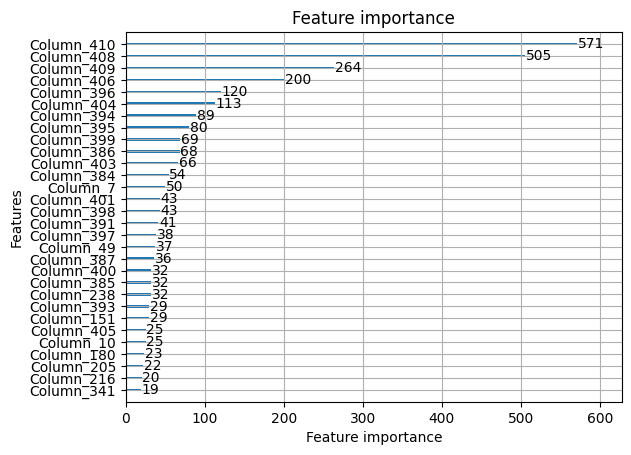

In [35]:
# Feature importance
# model_lgbm.feature_name = list(X_train_balanced.columns)
lgb.plot_importance(model_lgbm, max_num_features=30)
plt.show()

In [36]:
X_train_balanced

array([[ 0.        ,  0.        ,  0.        , ..., -0.14354878,
         0.01083437,  1.55597727],
       [ 0.        ,  0.        ,  0.        , ...,  1.44734371,
        -0.4893368 , -0.48468227],
       [ 0.        ,  0.        ,  0.        , ...,  1.44734371,
         0.01083437, -0.48468227],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.35557175,
        -0.75868566,  0.83839782],
       [ 0.        ,  0.        ,  0.        , ..., -0.93899502,
        -0.98950797, -1.65077343],
       [ 0.        ,  0.        ,  0.        , ..., -0.74013346,
         1.51134789,  0.97293169]])